In [1]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
import sentencepiece as spm


In [2]:
pathTrainValid=Path("../../data/nlp-data/fr/wiki-train_valid")

# Data preparation

Load the training and validation data we prepared in wiki_preparation.ipynb. In total 100 million articles with a split of 80% / 20% for training/validation:
- First column: text content to train the model. 
- Second column: Boolean representing if the data is for training or validation.

In [3]:
#create lm trainingfile with only two column
dfData = pd.read_csv(pathTrainValid/'train_and_valid.csv')

dfData.drop(["id","textWords"],axis=1,inplace=True)
display(dfData.head())

dfData.columns = ['content', 'is_valid']
dfData.head()
dfData.to_csv(pathTrainValid/"deepfrance.csv", index=None, header=None)
dfData=None
gc.collect()

,text,is_valid
0,Les icônes russes pré-mongoles sont les icônes...,False
1,L'élevage du cheval en Suisse fait partie de l...,False
2,Stanislas II Auguste aussi connu sous le nom d...,True
3,"De façon générale, l'intelligence collective d...",False
4,"Albert Hamilton Fish, né le 19 mai 1870 à Wash...",False


14

# Create Tokenizer
The sentencepiece vocabulary was trained in Train Sentencepiece tokenizer.ipynb.

Here we will make a BasicTokenizer from Sentencepiece so that fastai can use it instead of spacy

In [4]:
class SentencepieceTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        path,cache_name = pathTrainValid, "sp-model"
    #def __init__(self, path:PathOrStr, cache_name:str='sp-model'):
        self.pathVocab = path / cache_name
        self.vocab_    = Vocab(pickle.load(open(self.pathVocab/'itos.pkl', 'rb')))
        self.tok       = spm.SentencePieceProcessor()
        
        self.tok.Load(str(Path(path) / cache_name / 'm.model'))
        text.transform.UNK = "<unk>"

    #def __call__(self, language:str): return self    
        
    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
    def add_special_cases(self, toks:Collection[str]):
        #this should have been done when training sentencepiece
        pass
    
    def vocab(self): return self.vocab_

In [ ]:
spt       = SentencepieceTokenizer(lang="fr")
tokenizer = Tokenizer(SentencepieceTokenizer,"fr")

In [ ]:
print(spt.vocab().textify(np.arange(30)))

sentence = ["Elle est grande. Il est petit", "Il est petit. Elle est grande."]
#tokenizer._process_all_1(sentence)

<unk> xxbos xxpad xxmaj xxup xxrep xxwrep xxfld ▁de , ' . ▁la s ▁et ▁le ▁l ▁à ▁en ▁d ▁du ▁des - ▁est ▁les ▁un ▁dans ▁par ▁une ▁


In [ ]:
spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld", "▁de"]  )

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
tok = spt.vocab().itos
print(len(tok))
#[print(t) for t in tok]
tokenizer

32000


Tokenizer SentencepieceTokenizer in fr with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

# LM Training


We train two LM: one with a 60k vocabulary and one with a 30k vocabulary. The two models have different performance and computation needs.

In [ ]:
#import timeit start = timeit.default_timer()

vocab,max_vocab  = spt.vocab(), len(spt.vocab().itos)
#print(timeit.default_timer()-start )

In [ ]:
#%%debug
#import pdb; .set_trace() 


data_lm_full = TextLMDataBunch.from_csv( pathTrainValid, csv_name='deepfrance.csv', text_cols=0, label_cols=1,
                                         tokenizer=tokenizer, vocab=vocab,
                                         max_vocab=max_vocab,
                                         min_freq=0,
                                         chunksize=100
                                 )

NumericalizeProcessor.process


In [ ]:
data_lm_full.save('full_lm')

In [ ]:
data_lm_full = TextLMDataBunch.load(pathTrainValid, 'full_lm', bs=64)

In [ ]:
len(data_lm_full.train_ds.vocab.itos)

32000

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


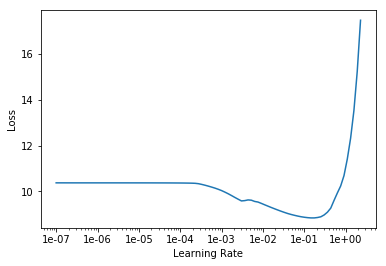

In [ ]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=False, pad_token=-1, callback_fns=ShowGraph)
learn.lr_find()
learn.recorder.plot(skip_start=0)

epoch,train_loss,valid_loss,accuracy
1,3.802052,3.937783,0.284765
2,3.459040,3.641307,0.310956
3,3.311515,3.566985,0.318131
4,3.248346,3.502161,0.325755
5,3.235970,3.432533,0.334170
6,3.156425,3.370527,0.341959
7,3.104218,3.297818,0.351766


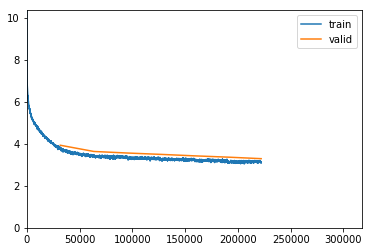

In [ ]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=False, pad_token=-1, callback_fns=ShowGraph)
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))

In [ ]:
learn.save('model-30k-sentencepiece-vocab')

In [ ]:
print(text.transform.BOS)
print(text.transform.FLD)
print(text.transform.PAD)
type(data_lm_full.train_ds.y)

In [ ]:
np.exp(4)

In [ ]:
np.exp(3.239415)

Now we train a model with a 30k vocabulary.
Because of this, batch size can be higher and training is quicker.

In [ ]:
data_lm_full = (TextList.from_csv(PATH, csv_name='fulltrain.csv', cols=0, processor=[TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=30000)])
           #Inputs: all the text files in path
            .split_from_df(col=1)
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=64))

In [ ]:
data_lm_full.save('full_lm_30k')

In [ ]:
data_lm_full = TextLMDataBunch.load(PATH, 'full_lm_30k', bs=64)

In [ ]:
len(data_lm_full.train_ds.vocab.itos)

In [ ]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=False, callback_fns=ShowGraph)
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [ ]:
learn = language_model_learner(data_lm_full, drop_mult=0, qrnn=False, callback_fns=ShowGraph)

In [ ]:
learn.fit_one_cycle(5, 1e-3)

The model perplexity is exp(validation loss):

In [ ]:
np.exp(3.377596)

In [ ]:
learn.save('model-30k-vocab')